In [1]:
import sys 
import os 
import datetime

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
from IPython.display import display, HTML


if "D:/src/PortAttribute" not in sys.path:
    sys.path.insert(0, "D:/src/PortAttribute")
if "D:/src/Backtest" not in sys.path:
    sys.path.insert(0, "D:/src/Backtest")
if "D:/src/OptPort" not in sys.path:
    sys.path.insert(0, "D:/src/OptPort")
if "D:/src/DataApi" not in sys.path:
    sys.path.insert(0, "D:/src/DataApi")
if "D:/src/" not in sys.path:
    sys.path.insert(0, "D:/src/")
if "D:/Nowcast/" not in sys.path:
    sys.path.insert(0, "D:/Nowcast/")
    
from portattr import plotting, ret_metric, exante
from fast_bt import simple_bt
from optport import max_ret, estimator, risk_parity, risk_budget, max_div, max_div_vol, min_var, max_ret, mean_variance
from dataapi import juyuan
from nowcast import api

In [2]:
DATA_PATH = "D:/data"
def read_data(name):
    data = pd.read_csv(DATA_PATH + "/{}.csv".format(name))
    data['date'] = pd.to_datetime(data['date'].astype(str))
    data = data.rename(columns={'date': '日期'})
    return data

In [28]:
asset_class = {
    'H00905.CSI': '中证500',
    'H00300.CSI': '沪深300',
    'CBA02501.CS': '利率债',
    'CBA02001.CS': '信用债',
    'AU9999.SGE': '黄金',
    'CN6112.CNI': '货币'
}
start_year = '2010'

prc = read_data("AssetClose")
prc = prc.loc[prc['field'].isin(asset_class.keys()), :]\
         .pivot(index='日期', columns='field', values='close')\
         .rename(columns=asset_class)
prc = prc.loc[:, ['沪深300', '中证500', '利率债', '信用债', '黄金', '货币']]

prc.index.name = 'date'
prc.columns.name = 'sid'
prc = prc.ffill()
daily_ret = prc.pct_change()

<AxesSubplot:xlabel='date'>

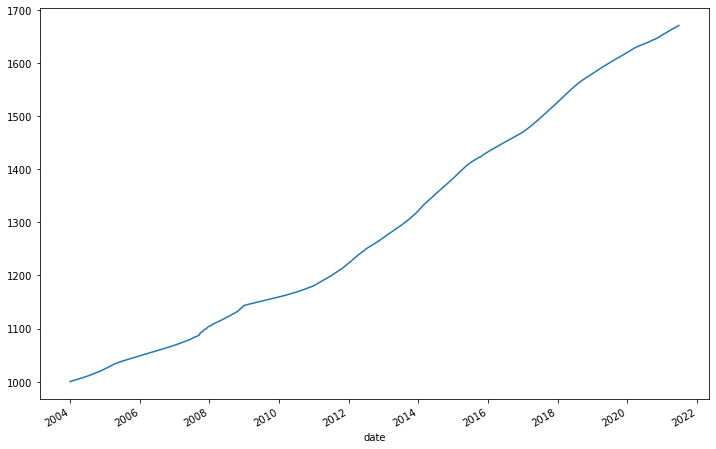

In [31]:
prc['货币'].plot(figsize=(12, 8))

In [4]:
bt_p = prc.loc[start_year: ].stack().to_frame('close')
bt_p['open'] = bt_p['close']
bt_p['vwap'] = bt_p['close']
bt_p = bt_p.sort_index()

In [6]:
def month_rebalance_date(dates_list, n=10):
    """
    """
    tmp = pd.DataFrame({'date': dates_list})
    tmp['month'] = tmp['date'].dt.month 
    tmp['year'] = tmp['date'].dt.year
    tmp['rank'] = tmp.groupby(['year', 'month'])['date'].rank().astype(int)
    tmp = tmp.query("rank == {}".format(n))
    return tmp['date'].tolist()

def quarter_rebalance_date(dates_list, month=[2,5,8,11], n=10):
    tmp = pd.DataFrame({'date': dates_list})
    tmp['date'] = pd.to_datetime(tmp['date'])
    tmp['month'] = tmp['date'].dt.month
    tmp['year'] = tmp['date'].dt.year
    tmp = tmp.loc[tmp['month'].isin(month)]
    tmp['rank'] = tmp.groupby(['year', 'month'])['date'].rank().astype(int)
    tmp = tmp.query("rank == {}".format(n))
    return tmp['date'].tolist()

def week_rebalance_date(dates_list, n=1):
    year, med, day = zip(*[x.isocalendar() for x in dates_list])
    tmp = pd.DataFrame({
            'dates': dates_list,
            'year': year,
            'med': med,
            'day': day
        })
    tmp['rank'] = tmp.groupby(["year", "med"])["day"].rank()
    return tmp.query("rank=={}".format(n))['dates'].tolist()

In [7]:
month_dates = month_rebalance_date(prc.loc[start_year:].index.tolist(), n=10)
week_dates = week_rebalance_date(prc.loc[start_year: ].index.tolist())
quarter_dates = quarter_rebalance_date(prc.loc[start_year:].index.tolist(), n=11)

In [8]:
# 组合
port_res = dict()
# 回测
bt_res = dict()
# 净值
nav_res = pd.DataFrame()
def show_bt_ret(start=start_year):
    return pd.DataFrame({
    x: ret_metric.cal_ret_summary(nav_res[x].iloc[1:, ].pct_change().loc[start:], 'daily',rf=0) for x in nav_res.columns
})
def show_mean_holding(start=start_year):
    return pd.DataFrame({
        x: port_res[x].loc[start:].mean() for x in port_res
    } )

In [9]:
var_dict = dict()

for dt in sorted(month_dates + quarter_dates):
    _temp = daily_ret.iloc[max(daily_ret.index.get_loc(dt) - 244 * 3, 0): daily_ret.index.get_loc(dt)]\
                     .loc[:, ['沪深300','中证500', '利率债', '信用债','黄金']]
    cov_es = estimator.exp_cov_estimator(_temp, halflife=126) * 244
    var_dict.update({dt: cov_es})

In [9]:
_temp_dict = dict()
for dt in sorted(quarter_dates + month_dates):
    cov_es = var_dict[dt]
    ret_es = pd.Series(np.diag(cov_es), index=cov_es.index) ** 0.5
    wgt = max_div_vol(var_dict[dt], 0.03, max_budget=0.95, max_holding=[0.4,0.4, 0.5, 0.3, 0.2])
    _temp_dict.update({dt: wgt})
_temp_dict = pd.DataFrame(_temp_dict)
_temp_dict = _temp_dict.T 
# _temp_dict = _temp_dict.div(_temp_dict.sum(axis=1), axis=0)
_temp_dict['货币'] = 0.05
port_res.update({'最大分散度3%': _temp_dict})
bt_res.update({
    '最大分散度3%_m': simple_bt(port_res['最大分散度3%'].reindex(month_dates), bt_p, init_cash=1e8)
})
nav_res['最大分散度3%_m'] = bt_res['最大分散度3%_m'].history_market_value + bt_res['最大分散度3%_m'].history_cash
bt_res.update({
    '最大分散度3%_q': simple_bt(port_res['最大分散度3%'].reindex(quarter_dates), bt_p, init_cash=1e8)
})
nav_res['最大分散度3%_q'] = bt_res['最大分散度3%_q'].history_market_value + bt_res['最大分散度3%_q'].history_cash

[Fast Backtest] default In Progress: 100%|########################################| 2874/2874 [00:04<00:00, 666.59it/s]


In [10]:
_temp_dict = dict()
for dt in sorted(quarter_dates + month_dates):
    cov_es = var_dict[dt]
    ret_es = pd.Series(np.diag(cov_es), index=cov_es.index) ** 0.5
    wgt = max_div_vol(var_dict[dt], 0.06, max_budget=0.95, max_holding=[0.4,0.4, 0.5, 0.3, 0.25])
    _temp_dict.update({dt: wgt})
_temp_dict = pd.DataFrame(_temp_dict)
_temp_dict = _temp_dict.T 
# _temp_dict = _temp_dict.div(_temp_dict.sum(axis=1), axis=0)
_temp_dict['货币'] = 0.05
port_res.update({'最大分散度6%': _temp_dict})
bt_res.update({
    '最大分散度6%_m': simple_bt(port_res['最大分散度6%'].reindex(month_dates), bt_p, init_cash=1e8)
})
nav_res['最大分散度6%_m'] = bt_res['最大分散度6%_m'].history_market_value + bt_res['最大分散度6%_m'].history_cash
bt_res.update({
    '最大分散度6%_q': simple_bt(port_res['最大分散度6%'].reindex(quarter_dates), bt_p, init_cash=1e8)
})
nav_res['最大分散度6%_q'] = bt_res['最大分散度6%_q'].history_market_value + bt_res['最大分散度6%_q'].history_cash

[Fast Backtest] default In Progress: 100%|########################################| 2874/2874 [00:04<00:00, 589.91it/s]


In [11]:
_temp_dict = dict()
for dt in sorted(quarter_dates + month_dates):
    cov_es = var_dict[dt]
    ret_es = pd.Series(np.diag(cov_es), index=cov_es.index) ** 0.5
    wgt = max_div_vol(var_dict[dt], 0.1, max_budget=0.95, max_holding=[0.4, 0.4, 0.5, 0.3, 0.25])
    _temp_dict.update({dt: wgt})
_temp_dict = pd.DataFrame(_temp_dict)
_temp_dict = _temp_dict.T 
# _temp_dict = _temp_dict.div(_temp_dict.sum(axis=1), axis=0)
_temp_dict['货币'] = 0.05
port_res.update({'最大分散度10%': _temp_dict})
bt_res.update({
    '最大分散度10%_m': simple_bt(port_res['最大分散度10%'].reindex(month_dates), bt_p, init_cash=1e8)
})
nav_res['最大分散度10%_m'] = bt_res['最大分散度10%_m'].history_market_value + bt_res['最大分散度10%_m'].history_cash
bt_res.update({
    '最大分散度10%_q': simple_bt(port_res['最大分散度10%'].reindex(quarter_dates), bt_p, init_cash=1e8)
})
nav_res['最大分散度10%_q'] = bt_res['最大分散度10%_q'].history_market_value + bt_res['最大分散度10%_q'].history_cash

[Fast Backtest] default In Progress: 100%|########################################| 2874/2874 [00:04<00:00, 624.55it/s]


In [12]:
_temp_dict = dict()
for dt in sorted(quarter_dates + month_dates):
    cov_es = var_dict[dt]
    ret_es = pd.Series(np.diag(cov_es), index=cov_es.index) ** 0.5
    wgt = risk_parity(var_dict[dt])
    _temp_dict.update({dt: wgt})
_temp_dict = pd.DataFrame(_temp_dict)
_temp_dict = _temp_dict.T 
_temp_dict *= 0.95
# _temp_dict = _temp_dict.div(_temp_dict.sum(axis=1), axis=0)
_temp_dict['货币'] = 0.05
port_res.update({'风险平价': _temp_dict})
bt_res.update({
    '风险平价_m': simple_bt(port_res['风险平价'].reindex(month_dates), bt_p, init_cash=1e8)
})
nav_res['风险平价_m'] = bt_res['风险平价_m'].history_market_value + bt_res['风险平价_m'].history_cash
bt_res.update({
    '风险平价_q': simple_bt(port_res['风险平价'].reindex(quarter_dates), bt_p, init_cash=1e8)
})
nav_res['风险平价_q'] = bt_res['风险平价_q'].history_market_value + bt_res['风险平价_q'].history_cash

[Fast Backtest] default In Progress: 100%|########################################| 2874/2874 [00:04<00:00, 636.84it/s]


In [13]:
show_bt_ret()

,最大分散度3%_m,最大分散度3%_q,最大分散度6%_m,最大分散度6%_q,最大分散度10%_m,最大分散度10%_q,风险平价_m,风险平价_q
夏普,1.47,1.49,0.76,0.77,0.54,0.55,2.79,2.71
总收益率,68.1%,70.3%,67.7%,70.3%,76.5%,80.5%,71.7%,70.7%
年化收益率,4.4%,4.5%,4.6%,4.7%,5.3%,5.5%,4.6%,4.5%
年化波动率,3.0%,3.1%,6.0%,6.1%,9.9%,10.1%,1.6%,1.7%
年化下行波动率,2.2%,2.3%,4.3%,4.3%,6.9%,7.1%,1.3%,1.3%
最大回撤,-5.7%,-5.6%,-10.4%,-10.6%,-19.4%,-19.8%,-3.6%,-3.6%
最大回撤期起,2013-02-15,2013-02-15,2018-01-26,2018-01-26,2018-01-26,2018-01-26,2016-10-24,2016-10-24
最大回撤期止,2013-12-20,2013-12-20,2018-10-11,2018-10-11,2018-10-30,2018-10-30,2016-12-20,2016-12-20
最长回撤期起,2013-02-15,2013-02-15,2013-02-15,2013-02-15,2010-11-09,2018-01-26,2010-10-19,2010-10-19
最长回撤期止,2014-07-23,2014-07-23,2014-12-05,2014-12-05,2013-01-25,2020-07-02,2011-11-02,2011-11-02


In [15]:
show_mean_holding()

,最大分散度3%,最大分散度6%,最大分散度10%,风险平价
沪深300,0.060276,0.133909,0.250769,0.027278
中证500,0.067939,0.148097,0.273524,0.032744
利率债,0.469933,0.332583,0.091091,0.408123
信用债,0.222614,0.106585,0.089139,0.430794
黄金,0.128993,0.228826,0.245477,0.051060
货币,0.050000,0.050000,0.050000,0.050000


In [5]:
from pypfopt.hierarchical_portfolio import HRPOpt

In [24]:
model = HRPOpt(daily_ret.loc['2016':].drop(['货币'], axis=1))

In [25]:
model.optimize()

OrderedDict([('中证500', 0.001111792358210708),
             ('信用债', 0.7006896653830076),
             ('利率债', 0.2897618904952645),
             ('沪深300', 0.0015488349414478388),
             ('黄金', 0.0068878168220694504)])

In [26]:
model.portfolio_performance()

(0.044191562596690596, 0.010717529975526888, 2.25719570198835)